In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [3]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f96665efc10>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f963df13100>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f963df13130>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f963df131c0>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f963df13250>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f963df13310>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f963df133a0>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f963df13430>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f963df13550>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f963df135b0>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f963df13640>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f963df13700>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f963df13760>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f963df137f0>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f963df13880>,
 'longitude': <scipy.io._n

## Extract Lat/Long

In [5]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
print(f"long: {np.amin(long)}, {np.max(long)}")
print(f"lat: {np.amin(lat)}, {np.max(lat)}")

long: -30.0625, -20.0625
lat: 19.9375, 59.9375


## Show data points on map

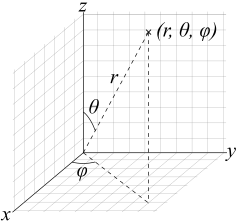
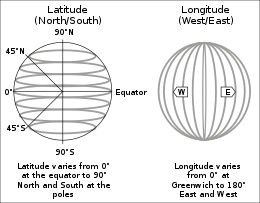
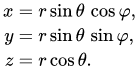

<IPython.core.display.Javascript object>


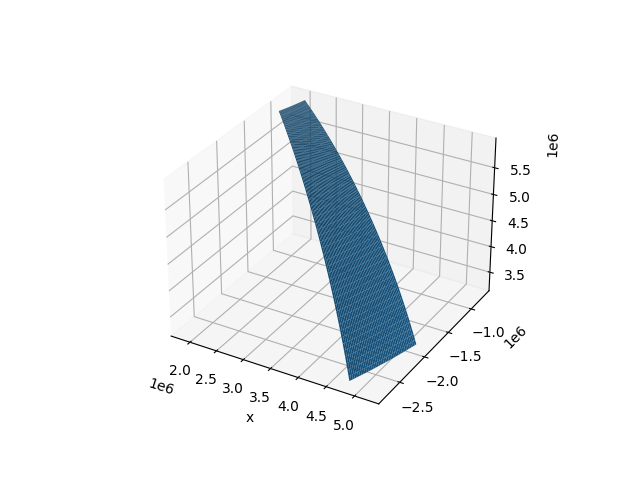

Text(0.5, 0, 'x')

In [4]:
radius = 6371e3 # obviously not the radius of the earth but makes plot less crazy
latv, longv = np.meshgrid(np.deg2rad(lat), np.deg2rad(long), indexing='ij')
x = radius * np.sin(latv) * np.cos(longv)
y = radius * np.sin(latv) * np.sin(longv)
z = radius * np.cos(latv)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x,y,z)
ax.set_xlabel("x")

## Extract Velocity

x component of velocity

<IPython.core.display.Javascript object>


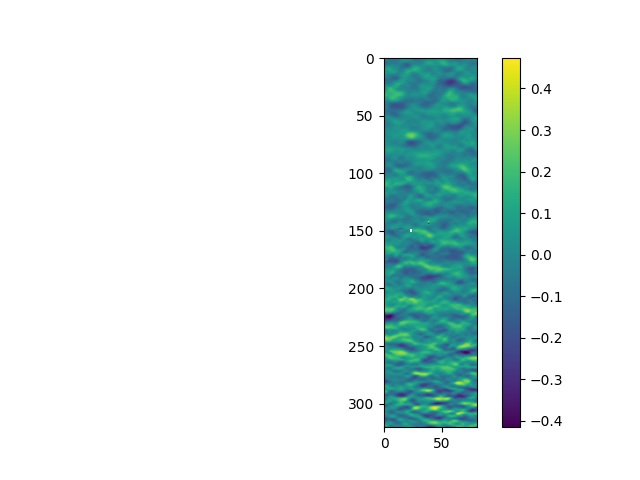

In [5]:
vel_x = f.variables['ugos'].data.squeeze()
vel_x.shape
plt.figure()
plt.imshow(vel_x)
plt.colorbar()

y component of velocity

<IPython.core.display.Javascript object>


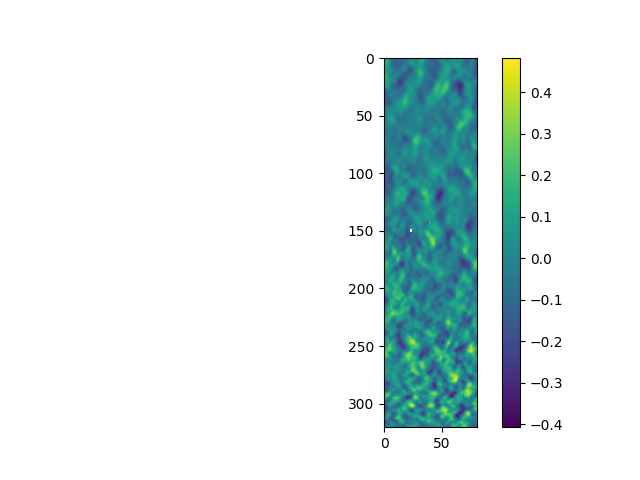

In [6]:
vel_y = f.variables['vgos'].data.squeeze()
vel_y.shape
plt.figure()
plt.imshow(vel_y)
plt.colorbar()

## Sea Surface Height

<IPython.core.display.Javascript object>


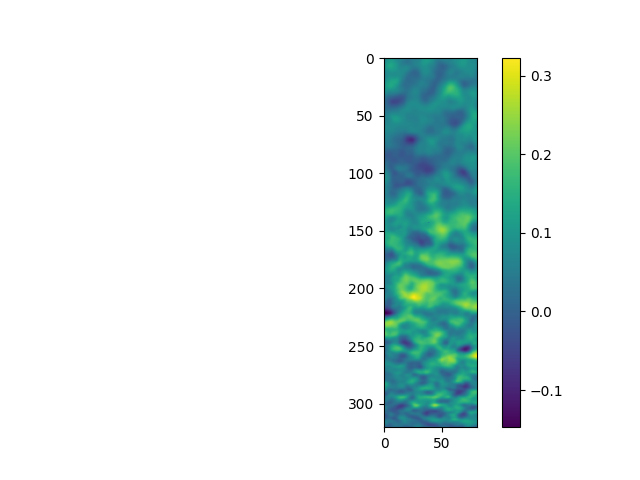

In [7]:
ssh = f.variables['sla'].data.squeeze()
plt.figure()
plt.imshow(ssh)
plt.colorbar()

## Are there any missing values?

In [8]:
print(f"Missing values in x: {np.isnan(np.amin(vel_x))}, at {np.argwhere(np.isnan(vel_x))}")
print(f"Missing values in y: {np.isnan(np.amin(vel_y))}, at {np.argwhere(np.isnan(vel_y))}")
print(f"Missing values in ssh: {np.isnan(np.amin(ssh))}, at {np.argwhere(np.isnan(ssh))}")

Missing values in x: True, at [[150  23]]
Missing values in y: True, at [[150  23]]
Missing values in ssh: False, at []


## Impute Missing Values using interpolation

In [9]:
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

## Plot data again to check nothing crazy has happened

<IPython.core.display.Javascript object>


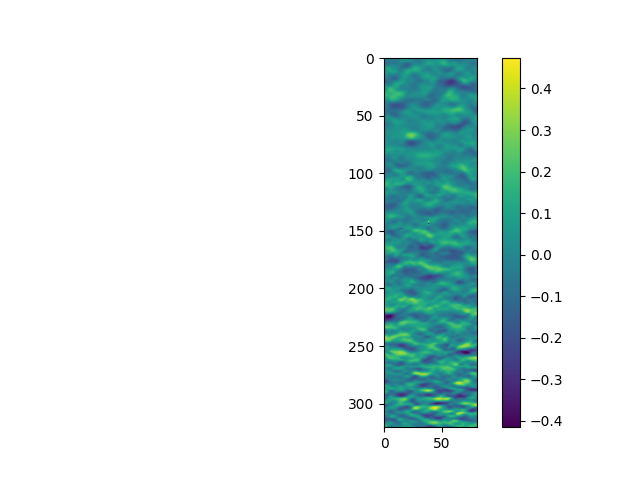

In [10]:
plt.figure()
plt.imshow(imputed_vel_x)
plt.colorbar()

<IPython.core.display.Javascript object>


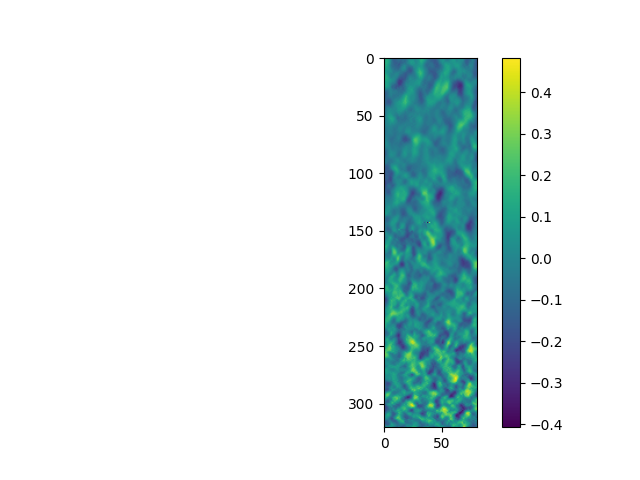

In [11]:
plt.figure()
plt.imshow(imputed_vel_y)
plt.colorbar()

## Quiver Plot

<IPython.core.display.Javascript object>


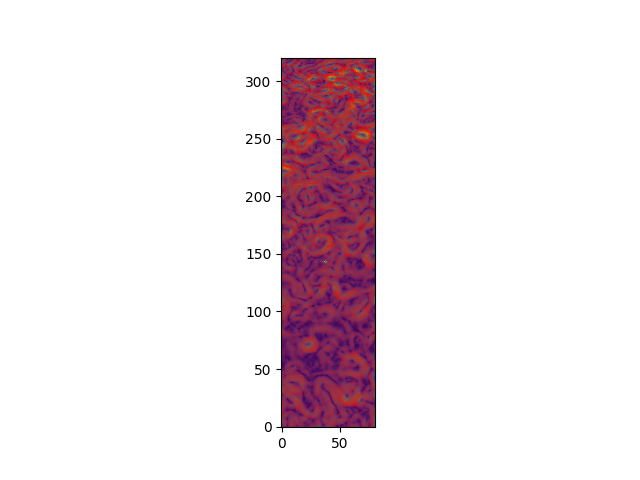

In [12]:
vel_magnitude = np.hypot(imputed_vel_x, imputed_vel_y)

# start with magnitude of velocity as background
plt.figure()
plt.imshow(vel_magnitude, origin='lower')
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5)

## Compute curl

Velocity Field $\mathbf{v}(x,y) = (v_x(x,y), v_y(x,y))$

$$
\nabla \times \mathbf{v} = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

<IPython.core.display.Javascript object>


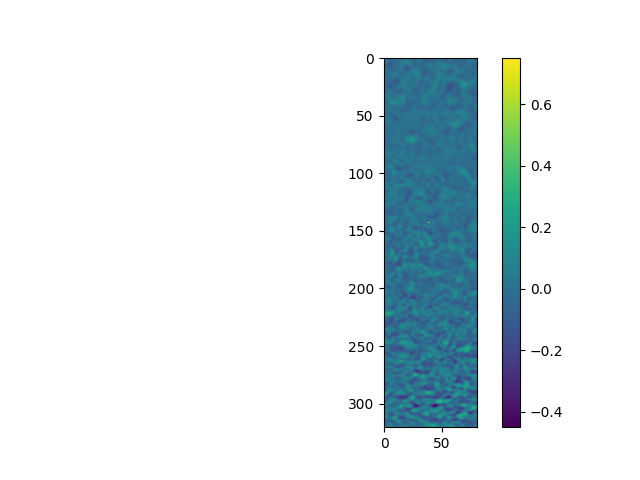

In [13]:
# would probably be good to compute the correct dx and dy
# or maybe we dont have to do this is we do some clever projection?
curl = np.gradient(imputed_vel_y, axis=1) - np.gradient(imputed_vel_x, axis=0)
plt.figure()
plt.imshow(curl)
plt.colorbar()

## Okubo–Weiss parameter
Okubo, A., 1970: Horizontal dispersion of floatable particles in the vicinity of velocity singularities such as convergences. Deep-Sea Res., 17, 445–454

A nice reference for how to actually calculate the thing: https://miolaseyne.ifremer.fr/sciences/ELISA/isern_AEs_Okubo.pdf

$$
W = s_n^2 + s_s^2 - \omega^2
$$

where $s_n$, $s_s$ and $\omega$ are the normal and the shear
components of strain and the curl of the flow defined respectively by

$$
s_n = \frac{\partial v_x}{\partial x} - \frac{\partial v_y}{\partial y}
$$

$$
s_s = \frac{\partial v_y}{\partial x} + \frac{\partial v_x}{\partial y}
$$

$$
\omega = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

<IPython.core.display.Javascript object>


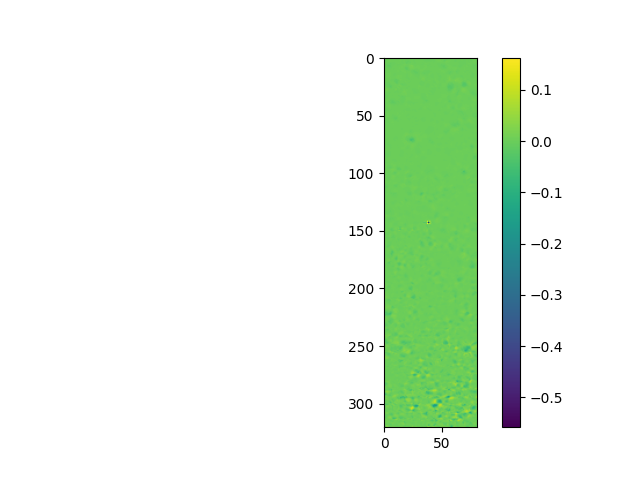

In [14]:
from common_functions import compute_okubo_weiss_parameter


W = compute_okubo_weiss_parameter(imputed_vel_x, imputed_vel_y)

plt.figure()
plt.imshow(W)
plt.colorbar()

## Thresholding

One naive approach might be to segement the eddies using a fixed threshold value

<IPython.core.display.Javascript object>


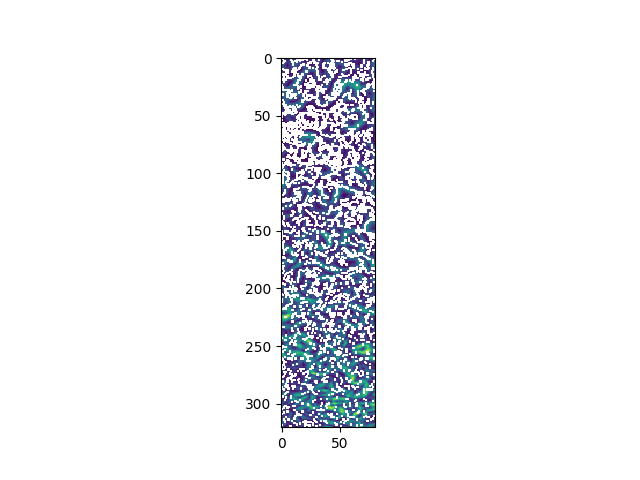

<IPython.core.display.Javascript object>


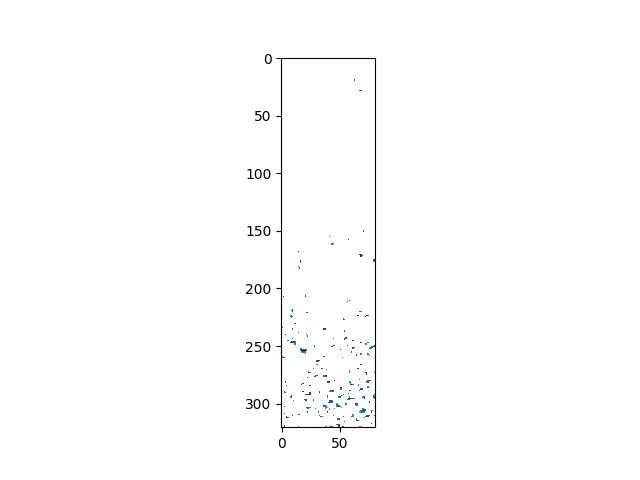

In [15]:
curl_eddies = np.ma.masked_where(np.abs(curl) < 0.01, vel_magnitude)
W_eddies = np.ma.masked_where(W < 0.01, vel_magnitude)

plt.figure()
plt.imshow(curl_eddies)
plt.figure()
plt.imshow(W_eddies)

## Spectral Clustering

## Find local maxima in the Sea Surface Height SSH

<IPython.core.display.Javascript object>


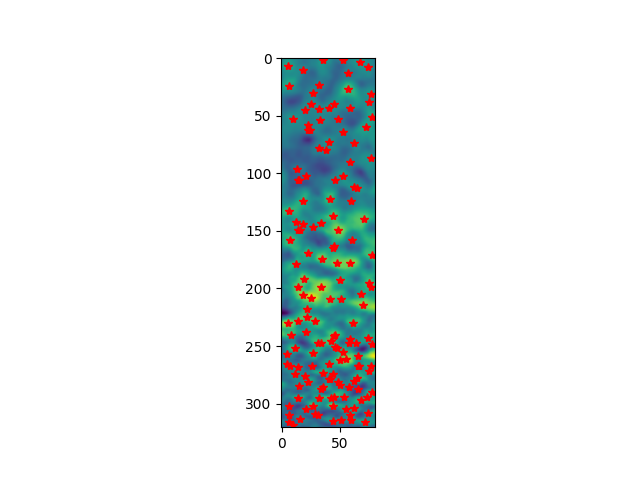

In [16]:
from skimage.feature import peak_local_max

peaks = peak_local_max(ssh)

plt.figure()
plt.imshow(ssh)
plt.plot(peaks[:,1], peaks[:,0], 'r*')

## Find Critical Points in Velocity field

<IPython.core.display.Javascript object>


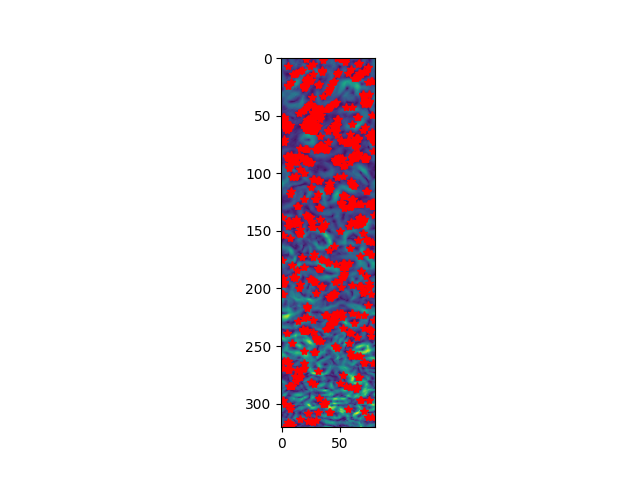

In [17]:
tol = 2e-2

crit_points = np.argwhere(vel_magnitude < tol)

plt.figure()
plt.imshow(vel_magnitude)
plt.plot(crit_points[:,1], crit_points[:,0], 'r*')

## Cross-referencing critical points with local maxima of ssh

<IPython.core.display.Javascript object>


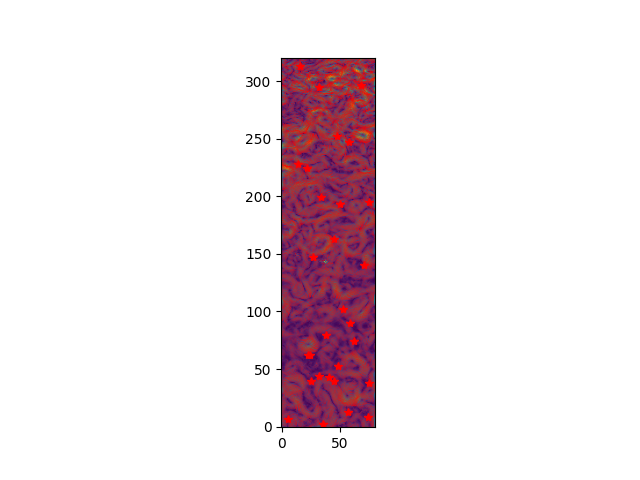

In [18]:
from scipy.spatial import distance

dists = distance.cdist(peaks, crit_points)

eddies = np.argwhere(dists < 0.1)[:, 0]

plt.figure()
plt.imshow(vel_magnitude, origin='lower')
plt.plot(peaks[eddies, 1], peaks[eddies, 0], 'r*')
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5)

## Integrating Particles

$$
\mathbf{x} = (x,y)
$$
$$
\dot{\mathbf{x}} = \mathbf{v}(\mathbf{x})
$$

<IPython.core.display.Javascript object>


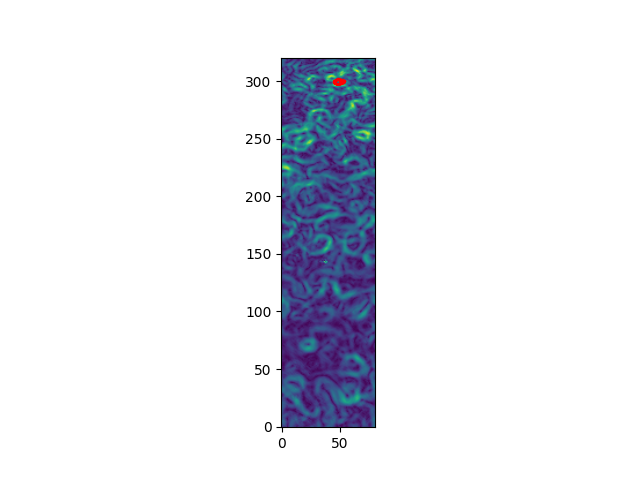

In [19]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
x = np.linspace(0, n, n)
y = np.linspace(0, m, m)
method = "linear"

interp_vel_x = RegularGridInterpolator((x, y), vel_x.T, method=method)
interp_vel_y = RegularGridInterpolator((x, y), vel_y.T, method=method)

def rhs(t, x):
    try:
        return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    except ValueError:
        # particle has left domain
        return [0, 0]

# ics of (55, 300) maybe an eddie?
sol = solve_ivp(rhs, (0, 500), [55, 300], max_step=1)
plt.figure()
plt.imshow(vel_magnitude, origin='lower', interpolation="bilinear")
plt.plot(sol.y[0], sol.y[1], 'r-')

Look at guassian curvature? A circle has curvature $\frac{1}{r^2}$